# Imports

In [14]:
# General imports
import os
import sys
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)
import scipy

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

from sklearn.cluster import KMeans

from tqdm import tqdm
# Other imports
tqdm.pandas()

import json

from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches

import random 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")
base_dir = yaml['base_directory']

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# RefSeq complete DF

In [7]:
refseq_wt_variable_drop_duplicates = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["Final"]["refseq_cds_without_variable"]).sort_values(by=['Gene', 'Exon_start'])
refseq_wt_variable_drop_duplicates

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,...,Ratio_num,Const_Alt,Share,CDS_count,ranges_without_variable,Miso_siso,Exon_start_raw,Exon_stop_raw,Length_raw,Exon_nb
7,A1BG,CDS,58347022-58347029,[NM_130786],58347022,58347029,7,0,1,[NM_130786],...,1.000000,Const,False,8,58347022-58347029,Siso,58347022,58347029,7,8
6,A1BG,CDS,58347353-58347640,[NM_130786],58347353,58347640,287,0,1,[NM_130786],...,1.000000,Const,False,8,58347353-58347640,Siso,58347353,58347640,287,7
5,A1BG,CDS,58350370-58350651,[NM_130786],58350370,58350651,281,0,1,[NM_130786],...,1.000000,Const,False,8,58350370-58350651,Siso,58350370,58350651,281,6
4,A1BG,CDS,58351391-58351687,[NM_130786],58351391,58351687,296,0,1,[NM_130786],...,1.000000,Const,False,8,58351391-58351687,Siso,58351391,58351687,296,5
3,A1BG,CDS,58352283-58352555,[NM_130786],58352283,58352555,272,0,1,[NM_130786],...,1.000000,Const,False,8,58352283-58352555,Siso,58352283,58352555,272,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207166,ZZZ3,CDS,77581776-77581888,"[NM_001376151, NM_001376149, NM_001376156, NM_...",77581776,77581888,112,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,True,13,77581776-77581891,Miso,77581776,77581891,115,5
207165,ZZZ3,CDS,77581979-77582126,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77581979,77582126,147,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,False,13,77581979-77582126,Miso,77581979,77582126,147,4
207164,ZZZ3,CDS,77584517-77584655,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77584517,77584655,138,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,False,13,77584517-77584655,Miso,77584517,77584655,138,3
207163,ZZZ3,CDS,77631850-77633354,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77631850,77633354,1504,0,8,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,0.727273,Alt,False,13,77631850-77633354,Miso,77631850,77633354,1504,2


## Remove variable exons 

In [ ]:
refseq_wt_variable = refseq.groupby('Gene').parallel_apply(exons_with_variable)

In [ ]:
refseq_wt_variable.loc[refseq_wt_variable['mRNA_gene_nb'] > 1, 'Miso_siso'] = 'Miso'
refseq_wt_variable.loc[refseq_wt_variable['mRNA_gene_nb'] == 1, 'Miso_siso'] = 'Siso'
refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']] = refseq_wt_variable['ranges_without_variable'].str.split('-', expand=True)
refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']] = refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']].astype(int)
refseq_wt_variable['Length_raw'] = refseq_wt_variable['Exon_stop_raw'] - refseq_wt_variable['Exon_start_raw']

In [2]:
refseq_wt_variable_path = yaml["1_GENOMICS"]["Final"]["refseq_cds_without_variable"]

if os.path.isfile(refseq_wt_variable_path) is False:
    # 
    refseq = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_cds_with_variable"]).sort_values(by=['Gene', 'Exon_start'])
    #
    refseq_wt_variable = refseq.groupby('Gene').parallel_apply(exons_with_variable)
    #
    refseq_wt_variable.loc[refseq_wt_variable['mRNA_gene_nb'] > 1, 'Miso_siso'] = 'Miso'
    refseq_wt_variable.loc[refseq_wt_variable['mRNA_gene_nb'] == 1, 'Miso_siso'] = 'Siso'
    refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']] = refseq_wt_variable['ranges_without_variable'].str.split('-', expand=True)
    refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']] = refseq_wt_variable[['Exon_start_raw', 'Exon_stop_raw']].astype(int)
    refseq_wt_variable['Length_raw'] = refseq_wt_variable['Exon_stop_raw'] - refseq_wt_variable['Exon_start_raw']
    
    #
    refseq_wt_variable_drop_duplicates = refseq_wt_variable.drop_duplicates(subset=['Gene', 'ranges_without_variable'])
    refseq_wt_variable_drop_duplicates = refseq_wt_variable_drop_duplicates.groupby('Gene').progress_apply(order_exon_by_strand_and_seq)
    refseq_wt_variable_drop_duplicates = refseq_wt_variable_drop_duplicates.reset_index(drop=True)
    refseq_wt_variable_drop_duplicates.to_parquet(refseq_wt_variable_path)
else:
    refseq_wt_variable_drop_duplicates = pd.read_parquet(refseq_wt_variable_path)
# refseq_wt_variable_drop_duplicates = refseq_wt_variable_drop_duplicates.loc[~refseq_wt_variable_drop_duplicates['Gene'].isin(genes_identical_cds)]
refseq_wt_variable_drop_duplicates

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,...,Ratio_num,Const_Alt,Share,CDS_count,ranges_without_variable,Miso_siso,Exon_start_raw,Exon_stop_raw,Length_raw,Exon_nb
0,A1BG,CDS,58864770-58864803,[NM_130786],58864770,58864803,33,0,1,[NM_130786],...,1.0,Const,False,8,58864770-58864803,Siso,58864770,58864803,33,1
1,A1BG,CDS,58864658-58864693,[NM_130786],58864658,58864693,35,0,1,[NM_130786],...,1.0,Const,False,8,58864658-58864693,Siso,58864658,58864693,35,2
2,A1BG,CDS,58864294-58864563,[NM_130786],58864294,58864563,269,0,1,[NM_130786],...,1.0,Const,False,8,58864294-58864563,Siso,58864294,58864563,269,3
3,A1BG,CDS,58863649-58863921,[NM_130786],58863649,58863921,272,0,1,[NM_130786],...,1.0,Const,False,8,58863649-58863921,Siso,58863649,58863921,272,4
4,A1BG,CDS,58862757-58863053,[NM_130786],58862757,58863053,296,0,1,[NM_130786],...,1.0,Const,False,8,58862757-58863053,Siso,58862757,58863053,296,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205622,ZZZ3,CDS,78044459-78044554,"[NM_001308237, NM_015534]",78044459,78044554,95,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78044459-78044554,Miso,78044459,78044554,95,8
205623,ZZZ3,CDS,78041753-78041905,"[NM_001308237, NM_015534]",78041753,78041905,152,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78041753-78041905,Miso,78041753,78041905,152,9
205624,ZZZ3,CDS,78034017-78034151,"[NM_001308237, NM_015534]",78034017,78034151,134,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78034017-78034151,Miso,78034017,78034151,134,10
205625,ZZZ3,CDS,78031766-78031866,"[NM_001308237, NM_015534]",78031766,78031866,100,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78031766-78031866,Miso,78031766,78031866,100,11


In [ ]:
# TODO
refseq_wt_variable_drop_duplicates.to_parquet(yaml["1_GENOMICS"]["Final"]["refseq_cds_without_variable"])

# RefSeq genes DF

In [16]:
genes_path_processed = yaml['1_GENOMICS']['Final']['refseq_genes_processed_miso_siso']

if os.path.isfile(base_dir + genes_path_processed) is False:

    genes = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_pc_genes"])
    genes['Gene'] = genes['Attributes'].apply(lambda r: [e.replace("Name=", "") for e in r.split(";") if "Name" in e][0])
    genes['Length'] = genes['End'] - genes['Start']
    genes.loc[genes['Gene'].isin(refseq_wt_variable_drop_duplicates.loc[refseq_wt_variable_drop_duplicates['Miso_siso'] == 'Miso']['Gene'].unique().tolist()), 'Miso_siso'] = 'Miso'
    genes.loc[genes['Gene'].isin(refseq_wt_variable_drop_duplicates.loc[refseq_wt_variable_drop_duplicates['Miso_siso'] == 'Siso']['Gene'].unique().tolist()), 'Miso_siso'] = 'Siso'
    genes = genes.dropna(subset=['Miso_siso'])
    genes['Length'] = genes['Length'] / 1000
    genes.to_parquet(base_dir + genes_path_processed, index=False)
else:
    genes = pd.read_parquet(base_dir + genes_path_processed)
# genes = genes.loc[~genes['Gene'].isin(genes_identical_cds)]
genes

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Gene,Length,Miso_siso
43,NC_000001.11,BestRefSeq,gene,65419,71585,.,+,.,"ID=gene-OR4F5;Dbxref=GeneID:79501,HGNC:HGNC:14...",OR4F5,6.166,Siso
243,NC_000001.11,BestRefSeq,gene,450740,451678,.,-,.,"ID=gene-OR4F29;Dbxref=GeneID:729759,HGNC:HGNC:...",OR4F29,0.938,Siso
287,NC_000001.11,BestRefSeq%2CGnomon,gene,683910,720115,.,-,.,"ID=gene-OR4F16;Dbxref=GeneID:81399,HGNC:HGNC:1...",OR4F16,36.205,Siso
452,NC_000001.11,BestRefSeq,gene,923923,944574,.,+,.,"ID=gene-SAMD11;Dbxref=GeneID:148398,HGNC:HGNC:...",SAMD11,20.651,Miso
539,NC_000001.11,BestRefSeq,gene,944203,959256,.,-,.,"ID=gene-NOC2L;Dbxref=GeneID:26155,HGNC:HGNC:24...",NOC2L,15.053,Siso
...,...,...,...,...,...,...,...,...,...,...,...,...
3643313,NC_000024.10,BestRefSeq,gene,25030901,25052104,.,-,.,"ID=gene-BPY2C;Dbxref=GeneID:442868,HGNC:HGNC:1...",BPY2C,21.203,Siso
3643388,NC_000024.10,BestRefSeq%2CGnomon,gene,25622095,25625511,.,+,.,"ID=gene-CDY1;Dbxref=GeneID:9085,HGNC:HGNC:1809...",CDY1,3.416,Miso
3643484,NC_000024.10,BestRefSeq,gene,56923423,56968979,.,+,.,"ID=gene-SPRY3-2;Dbxref=GeneID:10251,HGNC:HGNC:...",SPRY3,45.556,Miso
3643517,NC_000024.10,BestRefSeq%2CGnomon,gene,57067838,57130289,.,+,.,"ID=gene-VAMP7-2;Dbxref=GeneID:6845,HGNC:HGNC:1...",VAMP7,62.451,Miso


# RefSeq mRNA DF 

In [ ]:
mrnas = pd.read_parquet(yaml["1_GENOMICS"]["TMP"]["tmp_refseq_mrnas"])
mrnas['Gene'] = mrnas['Attributes'].apply(lambda r: [e.replace("Parent=gene-", "") for e in r.split(";") if "gene" in e][0])
mrnas

# UTRs

In [ ]:
utrs = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_miso_utrs"])
genes_identical_cds = utrs.loc[utrs['Nb_combi'] == 1].Gene.values.tolist()

# Plot functions

In [9]:
rcParams['font.size'] = 18

def custom_boxplot(data, x, y, ax, ylim, title="Title", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    if x:
        data = data.sort_values(by=x,ascending=True)
        sns.boxplot(data=data, x=x, y=y, showfliers=False, ax=ax, palette=palette, showmeans=True, meanline=False, 
                    meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
    else:
        sns.boxplot(data=data, y=y, showfliers=False, ax=ax, palette=palette)
        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x: 
        ax.spines['bottom'].set_linewidth(0)

        ax.axes.xaxis.set_visible(False)
    ax.set_axisbelow(True)

    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles=handles + 
                  [ matplotlib.lines.Line2D([0], [0], color=palette['Miso'], lw=10),
                    matplotlib.lines.Line2D([0], [0], color=palette['Siso'], lw=10),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
                    matplotlib.lines.Line2D([0], [0], color='black', lw=1)
                    ],  
              labels=labels + ["Miso", "Siso", 'Mean', "Median"], title='', ncol=1, bbox_to_anchor=(x_legend,0.5), loc='center right')
    else:
        ax.legend().remove()

    if x: 
        medians = data.groupby(x)[y].median()
        vertical_offset = data[y].median() * 0.25 # offset from median for display

        for xtick in ax.get_xticks():
            ax.text(xtick,medians[xtick] + padding_value_boxplot,round(medians[xtick],2), 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
    else:
        medians = data[y].median()
        vertical_offset = data[y].median() * 0.2 # offset from median for display
        for xtick in ax.get_xticks():
            ax.text(xtick,medians + padding_value_boxplot,medians, 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
    print(medians)


    
#     ax.spines['right'].set_linewidth(0)

    if x: 
        add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=box_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='outside', verbose=2)
    return ax



def custom_barplot(data, x="", y="", ax=[], ylim=(), title="", palette=['grey'], padding=10, padding_title=25, legend=False, remove_axis=False):
    
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

        
    def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
        def _show_on_single_plot(ax):
#             s_sum = list()
#             sub_list = list()
#             i_c = 1
#             for p in ax.patches:
#                 sub_list.append(p.get_height())
#                 if i_c % 2 == 0:
#                     s_sum.append(sub_list)
#                     sub_list = list()
#                 i_c += 1
#             print(s_sum)
#             s_sum = zip(s_sum[0], s_sum[1])
#             s_sum = [sum(e) for e in s_sum]
#             s_sum = s_sum + s_sum
#             print(s_sum)
#             s_sum = sum(s_sum)
#             print(s_sum)
            for j, p in enumerate(ax.patches):
                print(j, p)
#                 print('\n')
#                 print(p, p.get_height(), s_sum, float(int(p.get_height())/s_sum[j]))
#                 print('\n')
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + (p.get_height() / 2)
                if i == 0:
                    
                    value = "{:,}".format(int(p.get_height()))
                if i == 2:
                    value = "{:.2f}".format(p.get_height())

                if i == 3:
                    value = "{:.3f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
#                 ax.text(_x, _y - padding, "(" + str(int(100 * round(float(int(p.get_height())/s_sum[j]), 2))) + '%)', ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

#     plt.rcParams.update({'font.size' : 18})
#     f, ax = plt.subplots(figsize=(20,6))
#     data.plot(kind='bar', stacked=True, ax=ax, color=palette)
    ax.bar(data.columns, data.values, 0.5, label)
    
#     if x:
#         sns.barplot(data=data, x=x, y=y,  ax=ax, palette=palette)
#     else:
#         sns.barplot(data=data, y=y,  ax=ax, palette=palette)
    ax.grid(axis='y')

    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    
    if remove_axis is True:
        ax.spines['left'].set_linewidth(0)
#         ax.axes.get_yaxis().set_ticks([])


#     ax.spines['bottom'].set_linewidth(0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.set_axisbelow(True)
    ax.legend().remove()
#     print(ax.get_legend_handles_labels()[0][0])
#     ax.legend(ncol=2, bbox_to_anchor=(1.05,-0.1))
    
    


    
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x:
        ax.axes.xaxis.set_visible(False)
#         ax.spines['bottom'].set_linewidth(0)

    change_width(ax, .55)


    show_values_on_bars(ax, padding)

def custom_barplot2(data, x="", y="", ax=[], ylim=(), title="", palette=['grey'], padding=10, padding_title=25, legend=False):
    
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

        
    def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
        def _show_on_single_plot(ax):
            s_sum = list()
            for p in ax.patches:
                print(p)
                s_sum.append(p.get_height())
            s_sum = sum(s_sum)
#             print(s_sum)
            for p in ax.patches:
#                 print('\n')
#                 print(p, p.get_height(), s_sum, float(int(p.get_height())/s_sum))
#                 print('\n')
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + (p.get_height() / 2)
                if i == 0:
                    
                    value = "{:,}".format(int(p.get_height()))
                if i == 2:
                    value = "{:.2f}".format(p.get_height())

                if i == 3:
                    value = "{:.3f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
                ax.text(_x, _y - padding, "(" + str(int(100 * round(float(int(p.get_height())/s_sum), 2))) + '%)', ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

#     plt.rcParams.update({'font.size' : 18})
#     f, ax = plt.subplots(figsize=(20,6))
    data.plot(kind='bar', stacked=True, ax=ax, color=list(palette.values()))
    
#     if x:
#         sns.barplot(data=data, x=x, y=y,  ax=ax, palette=palette)
#     else:
#         sns.barplot(data=data, y=y,  ax=ax, palette=palette)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    ax.legend().remove()
#     print(ax.get_legend_handles_labels()[0][0])
#     ax.legend(ncol=2, bbox_to_anchor=(1.05,-0.1))
    
    


    
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x:
        ax.axes.xaxis.set_visible(False)
#         ax.spines['bottom'].set_linewidth(0)

    change_width(ax, .55)


    show_values_on_bars(ax, padding)

# Fig 1

In [ ]:
pd.DataFrame(refseq_wt_variable_drop_duplicates[["Gene", 'Miso_siso']].drop_duplicates()['Miso_siso'].value_counts()).T

In [ ]:
genes = refseq_wt_variable_drop_duplicates.groupby('Gene')[['Length']]

In [11]:
refseq_wt_variable_drop_duplicates

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,...,Ratio_num,Const_Alt,Share,CDS_count,ranges_without_variable,Miso_siso,Exon_start_raw,Exon_stop_raw,Length_raw,Exon_nb
7,A1BG,CDS,58347022-58347029,[NM_130786],58347022,58347029,7,0,1,[NM_130786],...,1.000000,Const,False,8,58347022-58347029,Siso,58347022,58347029,7,8
6,A1BG,CDS,58347353-58347640,[NM_130786],58347353,58347640,287,0,1,[NM_130786],...,1.000000,Const,False,8,58347353-58347640,Siso,58347353,58347640,287,7
5,A1BG,CDS,58350370-58350651,[NM_130786],58350370,58350651,281,0,1,[NM_130786],...,1.000000,Const,False,8,58350370-58350651,Siso,58350370,58350651,281,6
4,A1BG,CDS,58351391-58351687,[NM_130786],58351391,58351687,296,0,1,[NM_130786],...,1.000000,Const,False,8,58351391-58351687,Siso,58351391,58351687,296,5
3,A1BG,CDS,58352283-58352555,[NM_130786],58352283,58352555,272,0,1,[NM_130786],...,1.000000,Const,False,8,58352283-58352555,Siso,58352283,58352555,272,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207166,ZZZ3,CDS,77581776-77581888,"[NM_001376151, NM_001376149, NM_001376156, NM_...",77581776,77581888,112,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,True,13,77581776-77581891,Miso,77581776,77581891,115,5
207165,ZZZ3,CDS,77581979-77582126,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77581979,77582126,147,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,False,13,77581979-77582126,Miso,77581979,77582126,147,4
207164,ZZZ3,CDS,77584517-77584655,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77584517,77584655,138,0,11,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,1.000000,Const,False,13,77584517-77584655,Miso,77584517,77584655,138,3
207163,ZZZ3,CDS,77631850-77633354,"[NM_001376151, NM_001376149, NM_001376147, NM_...",77631850,77633354,1504,0,8,"[NM_001376156, NM_001376155, NM_001376147, NM_...",...,0.727273,Alt,False,13,77631850-77633354,Miso,77631850,77633354,1504,2


Rectangle(xy=(-0.275, 0), width=0.55, height=11356, angle=0)
Rectangle(xy=(-0.275, 11356), width=0.55, height=7911, angle=0)
Rectangle(xy=(-0.275, 0), width=0.55, height=54294, angle=0)
Rectangle(xy=(-0.275, 54294), width=0.55, height=7911, angle=0)
Miso_siso
Miso    35.666
Siso    14.202
Name: Length, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.107e+07
AxesSubplot(0.125,0.125;0.227941x0.755)
AxesSubplot(0.398529,0.125;0.227941x0.755)
AxesSubplot(0.672059,0.125;0.227941x0.755)


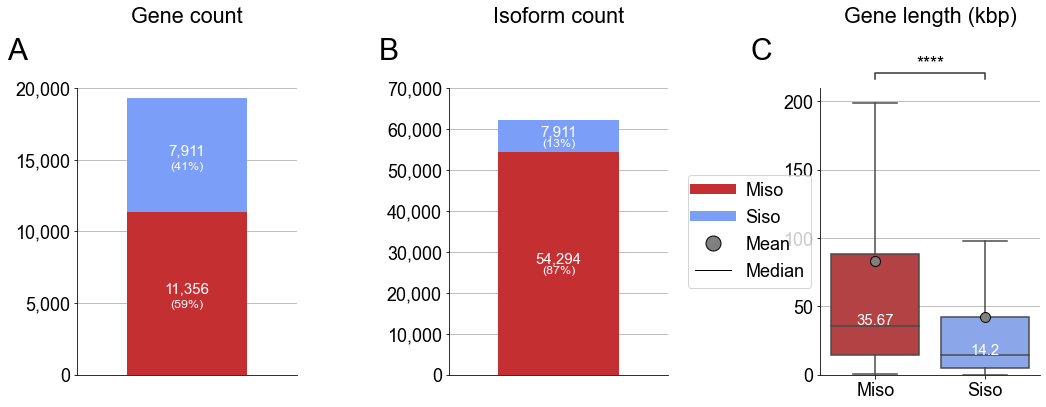

In [19]:
f, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,6))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
# palette={'Miso' : 'r', 'Siso' : 'g', }

barplot_genes_data = pd.DataFrame(refseq_wt_variable_drop_duplicates[["Gene", 'Miso_siso']].drop_duplicates()['Miso_siso'].value_counts()).T
barplot_genes_mrna_data = pd.DataFrame(refseq_wt_variable_drop_duplicates[["Gene", 'mRNA_gene', 'Miso_siso']].explode('mRNA_gene').drop_duplicates()['Miso_siso'].value_counts()).T

custom_barplot2(data=barplot_genes_data, x="", y="Gene", ax=ax[0], ylim=(0,20000), title="Gene count", padding=1000, padding_title=65, palette=palette)
custom_barplot2(data=barplot_genes_mrna_data, x="", y="mRNA_gene", ax=ax[1], ylim=(0,7e4), title="Isoform count", padding=2500, padding_title=65, palette=palette)
custom_boxplot(genes,"Miso_siso","Length",ax[2],(0,2.1e2),"Gene length (kbp)",[("Siso", "Miso")], palette=palette, padding_title=65, legend=True)



# custom_boxplot(
#     data_to_plot,"","ranges_without_variable",ax[0][2],(0,35),"Exons distribution / gene",[("Siso", "Miso")], padding_title=25
# )
# custom_boxplot(genes,"","Length",ax[1][0],(0,2e2),"Gene length (kbp)",[("Siso", "Miso")], padding_title=25)
# custom_boxplot(refseq_wt_variable_drop_duplicates,"","Length_raw",ax[1][1],(0,350),"Exon length (bp)",[("Siso", "Miso")], padding_title=25)
# custom_boxplot(refseq_introns_plot,"","Introns_lengths",ax[1][2],(0,1e1),"Intron length (kbp)",[("Siso", "Miso")], padding_title=25)

i = 0
for n, a in enumerate(ax):
    print(a)
#     for sub_a in a:
#     print(sub_a)
    a.text(-0.32, 1.1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
    i += 1
        
# plt.suptitle("Global", fontsize=25, y=1.05)        

plt.tight_layout()

# Supp Fig 1

In [ ]:

# CONFIG COLORS
color_aa = '#DC0000FF'
color_ab = '#F39B7FFF'
color_ba = '#00A087FF'
color_bb = '#91D1C2FF'

# SNS CONTEXT & FIG
sns.set_context('paper', font_scale=2)
f, ax = plt.subplots(ncols=1, figsize=(10,10), constrained_layout=True)

tmp = refseq_wt_variable_drop_duplicates.loc[refseq_wt_variable_drop_duplicates['Miso_siso'] == 'Miso'].explode('mRNA_gene')[['Gene', 'mRNA_gene']].reset_index(drop=True).groupby('Gene')['mRNA_gene'].nunique().value_counts()
tmp = pd.concat([tmp.rename('count'), tmp.cumsum().rename('mRNA_cumsum')], axis=1)
tmp['Ratio'] = tmp['count'] / tmp['count'].sum()
tmp['Ratio_cumsum'] = tmp['Ratio'].cumsum()

# Left barplot with y axis
ax1_ = ax.bar(tmp.index.tolist(), tmp['count'].values,
       align='edge',
       alpha=1,
       color=color_aa,
       width=-0.4
      )

# Right baprlot with y secondary axis
ax2 = ax.twinx()
ax2_ = ax2.bar(tmp.index.tolist(), tmp.Ratio_cumsum.values, alpha=0.5, color=color_ab, align='edge', width=0.4)

# AES
ax2.set_xlim(1.5,20.5)
ax.set_xticks(np.arange(2,21))
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: round(x, 0)))
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.yaxis.label.set_color(color_aa)
ax2.yaxis.label.set_color(color_ab)
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=color_aa, **tkw)
ax2.tick_params(axis='y', colors=color_ab, **tkw)
ax.set_ylabel('Count')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_xlabel('mRNA nb')
ax2.set_ylabel('Cumulative sum ratio')
ax.spines['top'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax.set_ylim(0,3500)
ax2.set_ylim(0,1)
# ax[0].text(-0.1, 1.05, 'a', transform=ax[0].transAxes, size=24, weight='bold')
ax2.grid(axis='y')



# Supp Table 1 

In [ ]:
global_stats = pd.DataFrame(pd.merge(refseq_wt_variable_drop_duplicates[["Gene", 'mRNA_gene']].explode('mRNA_gene').drop_duplicates(), genes, on='Gene').groupby(['Gene'])['mRNA_gene'].count().reset_index()['mRNA_gene'].describe()).T.rename({'mRNA_gene' : 'global'})
miso_siso_stats = pd.merge(refseq_wt_variable_drop_duplicates[["Gene", 'mRNA_gene']].explode('mRNA_gene').drop_duplicates(), genes, on='Gene').groupby(['Miso_siso', 'Gene'])['mRNA_gene'].count().reset_index().groupby('Miso_siso')['mRNA_gene'].describe()
output_isoforms_stats = pd.concat([global_stats, miso_siso_stats])
# output_isoforms_stats.to_excel('/gstock/EXOTIC/data/GENOMICS/isoforms_distribution.xlsx')
output_isoforms_stats

# Gene longest Intron & Exon 

In [ ]:
def compute_introns_ranges(r):
    l = list()
    exons = r["Exons_ranges"]
    exons_start = list(sorted([e.split("-")[0] for e in exons]))
    exons_end = list(sorted([e.split("-")[1] for e in exons]))
    exons = ["{}-{}".format(s, e) for s, e in zip(exons_start, exons_end)]

    for j, e in enumerate(exons):
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    r["Introns_ranges"] = l
    r["Introns_lengths"] = [int(e.split("-")[1]) - int(e.split("-")[0]) for e in l
                            #                 if int(e.split("-")[1]) - int(e.split("-")[0]) > 0 and int(e.split("-")[1]) - int(e.split("-")[0]) < 2e6
            ]
        
    return r

In [ ]:
refseq_introns = pd.merge(refseq_wt_variable_drop_duplicates.reset_index(drop=True).groupby('Gene')['ranges_without_variable'].apply(list).reset_index(), refseq_wt_variable_drop_duplicates.reset_index(drop=True)[['Gene', 'Strand', 'Miso_siso']].drop_duplicates(), on='Gene').rename({'ranges_without_variable':'Exons_ranges'},axis=1)
refseq_introns = refseq_introns.progress_apply(compute_introns_ranges, axis=1)
refseq_introns

In [6]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

refseq_introns_plot_path = yaml['1_GENOMICS']['Final']['refseq_introns_plot']

if os.path.isfile(refseq_introns_plot_path) is False:

    refseq_introns = pd.merge(
        refseq_wt_variable_drop_duplicates.reset_index(drop=True).groupby('Gene')['ranges_without_variable'].apply(list).reset_index(), 
        refseq_wt_variable_drop_duplicates.reset_index(drop=True)[['Gene', 'Strand', 'Miso_siso']].drop_duplicates(), 
        on='Gene').rename({'ranges_without_variable':'Exons_ranges'},axis=1)
    refseq_introns = refseq_introns.progress_apply(compute_introns_ranges, axis=1)

    refseq_introns_plot = refseq_introns.explode('Introns_lengths').dropna(subset=['Introns_lengths'])
    refseq_introns_plot['Introns_lengths'] = refseq_introns_plot['Introns_lengths'].astype(int)
    refseq_introns_plot['Introns_lengths']  = refseq_introns_plot['Introns_lengths'] / 1000
    refseq_introns_plot = pd.merge(genes[['Gene', 'Length']], refseq_introns_plot, on ='Gene')
    refseq_introns_plot = refseq_introns_plot.loc[(refseq_introns_plot['Introns_lengths'] > 0) & (refseq_introns_plot['Introns_lengths'] < refseq_introns_plot['Length'])].drop(['Length'], axis=1)

    refseq_introns_plot.to_parquet(refseq_introns_plot_path)
else: 
    refseq_introns_plot = pd.read_parquet(refseq_introns_plot_path)
# refseq_introns_plot = refseq_introns_plot.loc[~refseq_introns_plot['Gene'].isin(genes_identical_cds)]
refseq_introns_plot

,Gene,Exons_ranges,Strand,Miso_siso,Introns_ranges,Introns_lengths
0,SAMD11,"[861322-861393, 865535-865716, 866419-866469, ...",1,Siso,"[861394-865534, 865717-866418, 866470-871151, ...",4.140
1,SAMD11,"[861322-861393, 865535-865716, 866419-866469, ...",1,Siso,"[861394-865534, 865717-866418, 866470-871151, ...",0.701
2,SAMD11,"[861322-861393, 865535-865716, 866419-866469, ...",1,Siso,"[861394-865534, 865717-866418, 866470-871151, ...",4.681
3,SAMD11,"[861322-861393, 865535-865716, 866419-866469, ...",1,Siso,"[861394-865534, 865717-866418, 866470-871151, ...",3.142
4,SAMD11,"[861322-861393, 865535-865716, 866419-866469, ...",1,Siso,"[861394-865534, 865717-866418, 866470-871151, ...",0.144
...,...,...,...,...,...,...
186562,DAZ4,"[26980274-26980276, 26986878-26987024, 2698729...",1,Miso,"[26980277-26986877, 26987025-26987298, 2698739...",4.571
186563,BPY2C,"[27190093-27190170, 27187916-27188033, 2718495...",0,Siso,"[27184264-27184955, 27185062-27187915, 2718803...",0.691
186564,BPY2C,"[27190093-27190170, 27187916-27188033, 2718495...",0,Siso,"[27184264-27184955, 27185062-27187915, 2718803...",2.853
186565,BPY2C,"[27190093-27190170, 27187916-27188033, 2718495...",0,Siso,"[27184264-27184955, 27185062-27187915, 2718803...",2.058


In [ ]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")
refseq_introns_plot_path = yaml['1_GENOMICS']['Final']['refseq_introns_plot']

refseq_introns_plot.to_parquet(refseq_introns_plot_path)


In [ ]:
refseq_introns_plot['Exon_lengths'] = refseq_introns_plot.Exons_ranges.progress_apply(lambda r: [int(e.split('-')[1]) - int(e.split('-')[0]) for e in r])
refseq_introns_plot

In [7]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

output_path = yaml['1_GENOMICS']['Final']['refseq_introns_max']

if os.path.isfile(output_path) is False:

    def test_intron_nb(df):
        df['Intron_nb'] = list(range(1, df.shape[0] + 1))
        df['Intron_length_max'] = df.Introns_lengths.max()
        df['Intron_length_max_index'] = df.Introns_lengths.tolist().index(df.Introns_lengths.max()) + 1
        return df

    t = pd.merge(genes[['Gene', 'Length']], refseq_introns_plot, on='Gene')

    t = t.groupby('Gene').parallel_apply(test_intron_nb)
    t = pd.merge(t, refseq_wt_variable_drop_duplicates[['Gene', 'mRNA_gene_nb', 'CDS_count']].reset_index(drop=True), on='Gene')

    t_introns = t[['Gene', 'Length', 'Miso_siso', "Intron_length_max", "Intron_length_max_index",  'mRNA_gene_nb', 'CDS_count', "Strand"]].drop_duplicates()
    t_introns['Intron_length_norm'] = t['Intron_length_max'] / t['Length']

    t_introns.to_parquet(output_path, index=False)
else:
    t_introns = pd.read_parquet(output_path)
    
# t = t.loc[~t['Gene'].isin(genes_identical_cds)]

t_introns


,Gene,Length,Miso_siso,Intron_length_max,Intron_length_max_index,mRNA_gene_nb,CDS_count,Strand,Intron_length_norm
0,SAMD11,18.843,Siso,4.681,3,1,13,1,0.248421
1,NOC2L,15.053,Siso,2.522,7,1,19,0,0.167541
2,KLHL17,5.135,Siso,0.491,1,1,12,1,0.095618
3,PLEKHN1,9.383,Miso,3.472,2,3,17,1,0.370031
4,PERM1,6.895,Miso,2.255,2,4,6,0,0.327049
...,...,...,...,...,...,...,...,...,...
16276,BPY2B,21.203,Siso,2.853,2,1,4,1,0.134556
16277,DAZ3,50.423,Siso,9.714,3,1,18,0,0.192650
16278,DAZ4,73.220,Miso,14.472,18,2,22,1,0.197651
16279,BPY2C,21.203,Siso,2.853,2,1,4,0,0.134556


In [ ]:
refseq_wt_variable_drop_duplicates.columns

In [8]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

output_path = yaml['1_GENOMICS']['Final']['refseq_exons_max']

if os.path.isfile(output_path) is False:

    def test_exon_nb(df):
        df['Exon_length_max'] = df.Length_raw.max()
        df['Exon_length_max_index'] = df.Length_raw.tolist().index(df.Exon_length_max.max()) + 1
        return df

#     t = pd.merge(genes[['Gene']], refseq_introns_plot, on='Gene')
    t = refseq_wt_variable_drop_duplicates.copy()

    t = t.groupby('Gene').parallel_apply(test_exon_nb)
#     t = pd.merge(t, refseq_wt_variable_drop_duplicates[['Gene', 'mRNA_gene_nb', 'CDS_count']].reset_index(drop=True), on='Gene')

    t_exons = t[['Gene', 'Length', 'Miso_siso', "Exon_length_max", "Exon_length_max_index",  'mRNA_gene_nb', 'CDS_count', "Strand"]].drop_duplicates(subset=['Gene'])
#     t['Intron_length_norm'] = t['Intron_length_max'] / t['Length']

    t_exons.to_parquet(output_path, index=False)
else:
    t_exons = pd.read_parquet(output_path)
    
# t = t.loc[~t['Gene'].isin(genes_identical_cds)]

t_exons


,Gene,Length,Miso_siso,Exon_length_max,Exon_length_max_index,mRNA_gene_nb,CDS_count,Strand
0,A1BG,33,Siso,296,5,1,8,0
1,A1CF,98,Miso,273,8,8,13,0
2,A2M,85,Miso,228,19,4,38,0
3,A2ML1,61,Miso,228,20,2,36,1
4,A3GALT2,22,Siso,687,5,1,5,0
...,...,...,...,...,...,...,...,...
19301,ZYG11A,89,Miso,751,3,2,15,1
19302,ZYG11B,29,Siso,754,3,1,14,1
19303,ZYX,207,Miso,521,4,3,9,1
19304,ZZEF1,353,Siso,468,29,1,55,0


In [ ]:

output_path = yaml['1_GENOMICS']['Final']['refseq_introns_exons_max']

if os.path.isfile(output_path) is False:

    def test_intron_nb(df):

    #     print(list(range(1, df.shape[0] + 1)))
        df['Intron_nb'] = list(range(1, df.shape[0] + 1))

        df['Intron_length_max'] = df.Introns_lengths.max()
        df['Intron_length_max_index'] = df.Introns_lengths.tolist().index(df.Introns_lengths.max()) + 1
        df['Exon_length_max'] = df.Exons_ranges.apply(lambda r: max([int(e.split('-')[1]) - int(e.split('-')[0]) for e in r]))
    #     print(df)
        return df

    t = pd.merge(genes[['Gene', 'Length']], refseq_introns_plot, on='Gene')

    t = t.groupby('Gene').parallel_apply(test_intron_nb)
    t = pd.merge(t, refseq_wt_variable_drop_duplicates[['Gene', 'mRNA_gene_nb', 'CDS_count']].reset_index(drop=True), on='Gene')

    t = t[['Gene', 'Length', 'Miso_siso', "Intron_length_max", "Intron_length_max_index",  'mRNA_gene_nb', 'CDS_count', "Strand", "Exon_length_max"]].drop_duplicates()
    t['Intron_length_norm'] = t['Intron_length_max'] / t['Length']

    t.to_parquet(output_path, index=False)
else:
    t_introns = pd.read_parquet(output_path)
    
# t = t.loc[~t['Gene'].isin(genes_identical_cds)]

t_introns


No handles with labels found to put in legend.


Rectangle(xy=(-0.275, 0), width=0.55, height=142874, angle=0)
Rectangle(xy=(-0.275, 142874), width=0.55, height=64300, angle=0)
Miso_siso
Miso    10
Siso     5
Name: ranges_without_variable, dtype: int64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.286e+07


No handles with labels found to put in legend.


Miso_siso
Miso    119
Siso    127
Name: Length_raw, dtype: int64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.762e-193 U_stat=4.220e+09
AxesSubplot(0.125,0.125;0.168478x0.755)
AxesSubplot(0.327174,0.125;0.168478x0.755)
AxesSubplot(0.529348,0.125;0.168478x0.755)
AxesSubplot(0.731522,0.125;0.168478x0.755)


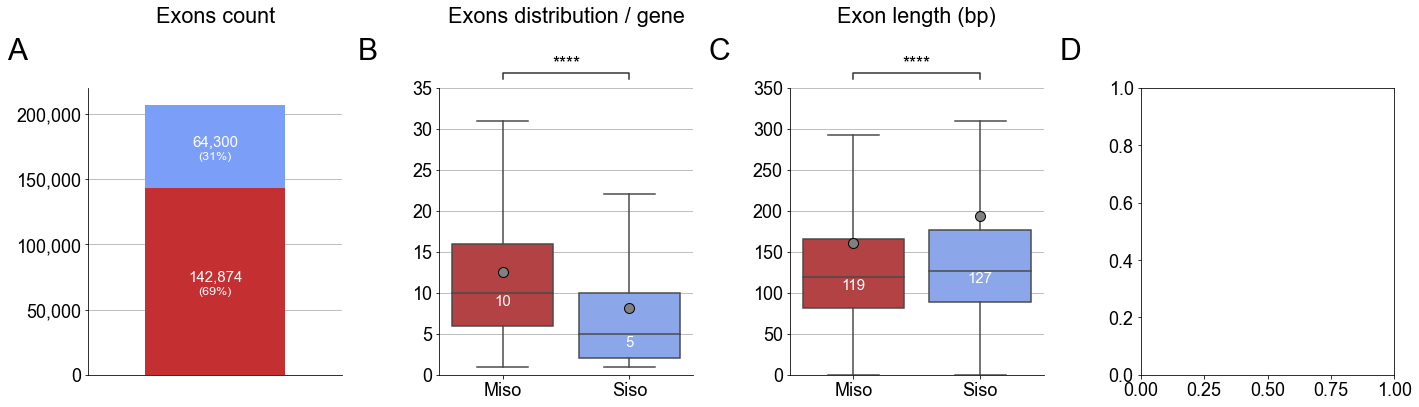

In [21]:
f, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,6))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
# palette={'Miso' : 'r', 'Siso' : 'g', }

barplot_exons_count = pd.DataFrame(refseq_wt_variable_drop_duplicates['Miso_siso'].value_counts()).T
data_to_plot = refseq_wt_variable_drop_duplicates.reset_index(drop=True).groupby(['Gene', 'Miso_siso'])['ranges_without_variable'].nunique().reset_index()


# custom_barplot2(data=barplot_genes_mrna_data, x="", y="mRNA_gene", ax=ax[1], ylim=(0,6e4), title="Isoform count", padding=2500, padding_title=65, palette=palette)
# custom_boxplot(genes,"Miso_siso","Length",ax[2],(0,2e2),"Gene length (kbp)",[("Siso", "Miso")], palette=palette, padding_title=65, )


custom_barplot2(data=barplot_exons_count, x="", y="Gene", ax=ax[0], ylim=(0,2.2e5), title="Exons count", padding=10000, padding_title=65, palette=palette)

custom_boxplot(data=data_to_plot,x="Miso_siso",y="ranges_without_variable",ax=ax[1],ylim=(0,35),title="Exons distribution / gene",box_pairs=[("Siso", "Miso")], legend=False, padding_title=65, padding_value_boxplot=-1.5 , palette=palette)
custom_boxplot(data=refseq_wt_variable_drop_duplicates,x="Miso_siso",y="Length_raw",ax=ax[2],ylim=(0,350),title="Exon length (bp)",box_pairs=[("Siso", "Miso")],  legend=False, padding_title=65, padding_value_boxplot=-15, palette=palette)
# custom_boxplot(data=refseq_introns_plot,x="Miso_siso",y="Introns_lengths",ax=ax[3],ylim=(0,1e1),title="Intron length (kbp)",box_pairs=[("Siso", "Miso")],  legend=True, padding_title=65, padding_value_boxplot=-0.5, palette=palette)

i = 0
for n, a in enumerate(ax):
    print(a)
#     for sub_a in a:
#     print(sub_a)
    a.text(-0.32, 1.1, string.ascii_uppercase[i], transform=a.transAxes, size=30, weight='bold')
    i += 1
        
# plt.suptitle("Global", fontsize=25, y=1.05)        

plt.tight_layout()

In [ ]:
# plt.style.use('default')
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0, padding=1):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + padding
            if i == 0:
                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
plt.rcParams.update({'font.size' : 18})
        
f, ax = plt.subplots(nrows=2, figsize=(18,10))

sns.barplot(data=t_introns.loc[t_introns['CDS_count'] <= 30].groupby('CDS_count')['Intron_length_max'].mean().reset_index(), x='CDS_count', y='Intron_length_max', palette=['grey'], ax=ax[0])
ax[0].plot([0, 8], [9,21], color='red', lw=2, marker='o')
ax[0].plot([9,13], [22,22], color='red', lw=2, marker='o')
ax[0].plot([14, 20], [27,27], color='red', lw=2, marker='o')
ax[0].plot([21, 28], [35,35], color='red', lw=2, marker='o')

ax[0].spines['right'].set_linewidth(0)
ax[0].spines['top'].set_linewidth(0)
ax[0].set_ylabel('Longest intron mean length (kbp)')
ax[0].set_xlabel('')
ax[0].set_xlim(-0.5,28.5)
ax[0].set_axisbelow(True)
ax[0].grid(axis='y')
ax[0].set_title('Global')

print(ax[0].get_xticks())
show_values_on_bars(ax[0], fontsize=11)


sns.barplot(data=t.loc[t['CDS_count'] <= 30].groupby(['Miso_siso', 'CDS_count'])['Intron_length_max'].mean().reset_index(), x='CDS_count', y='Intron_length_max', hue='Miso_siso', palette=palette, ax=ax[1])
ax[1].spines['right'].set_linewidth(0)
ax[1].spines['top'].set_linewidth(0)
ax[1].set_ylabel('Longest intron mean length (kbp)')
ax[1].set_xlabel('Number of exons in the gene')
ax[1].set_axisbelow(True)
ax[1].grid(axis='y')
ax[1].legend(title='')
ax[1].set_title('Miso & Siso')

show_values_on_bars(ax[1], fontsize=11)



i = 0
for n, sub_a in enumerate(ax):
    sub_a.text(-0.075, 1.05, string.ascii_uppercase[i], transform=sub_a.transAxes, size=35, weight='bold')
    i += 1 
plt.tight_layout()

In [ ]:
t

No handles with labels found to put in legend.


Miso_siso
Miso    9.7490
Siso    5.7655
Name: Intron_length_max, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.996e-120 U_stat=3.894e+07


Text(-0.2, 1.25, 'C')

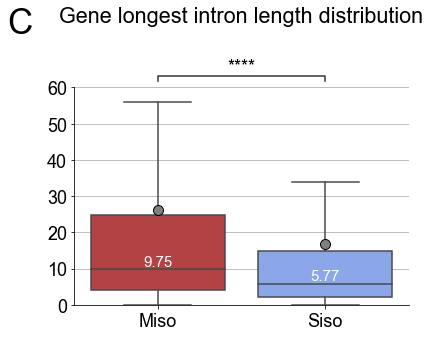

In [53]:
f, ax = plt.subplots()
# sns.boxplot(data=t, x='Miso_siso', y='Intron_length_max', showfliers=False)
custom_boxplot(t_introns,"Miso_siso","Intron_length_max",ax,(0,60),"Gene longest intron length distribution",[("Siso", "Miso")], palette=palette, padding_title=65, legend=False, x_legend=1.5)
ax.text(-0.2, 1.25, "C", transform=ax.transAxes, size=35, weight='bold')

Miso_siso
Miso    291
Siso    380
Name: Exon_length_max, dtype: int64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.729e-34 U_stat=4.107e+07


Text(-0.2, 1.25, 'D')

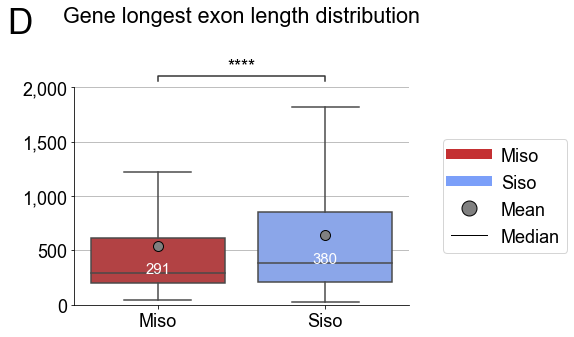

In [52]:
f, ax = plt.subplots()
# sns.boxplot(data=t, x='Miso_siso', y='Intron_length_max', showfliers=False)
t_exons_plot = t_exons.copy()
custom_boxplot(t_exons_plot,"Miso_siso","Exon_length_max",ax,(0,2e3),"Gene longest exon length distribution",[("Siso", "Miso")], palette=palette, padding_title=65, legend=True, x_legend=1.5)
ax.text(-0.2, 1.25, "D", transform=ax.transAxes, size=35, weight='bold')

In [ ]:
f, ax = plt.subplots(figsize=(15,8))
t_exons_plot = t_exons.loc[(t_exons['CDS_count'] <= 10) & (t_exons['Miso_siso'] == 'Siso')]
sns.boxplot(data=t_exons_plot, x='Exon_length_max_index', y='Exon_length_max', hue='CDS_count', showfliers=False, 
           showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})

# g = sns.FacetGrid(data=t_exons_plot, row='CDS_count', height=4, aspect=3)
# g.map_dataframe(sns.boxplot, x='Exon_length_max_index', y='Exon_length_max', showfliers=False, 
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
ax.set_ylim(0,2.5e3)

2371.0 4815.0
1321.0 2353.0
1039.0 1710.0
769.0 1209.0
607.0 973.0
498.0 774.0
424.0 650.0
323.0 529.0
302.0 433.0
259.0 363.0
2444.0 4815.0
1032.0 2353.0
671.0 1710.0
440.0 1209.0
366.0 973.0
276.0 774.0
226.0 650.0
206.0 529.0
131.0 433.0
104.0 363.0


Text(-0.1, 1.05, 'A')

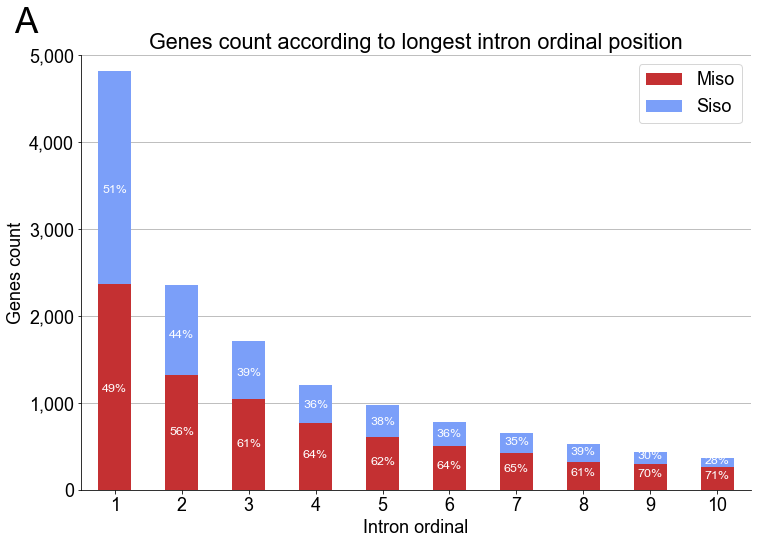

In [36]:
# plt.style.use('default')
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        i = 1
        s_sum = list()
        s_sum_complete = list()
        for p in ax.patches:
            s_sum.append(p.get_height())
            if i % 10 == 0 :
                s_sum_complete.append(s_sum)
                s_sum = list()
            i += 1
        
        s_sum_complete = list(zip(s_sum_complete[0], s_sum_complete[1]))
        s_sum_complete = [sum(e) for e in s_sum_complete]
        s_sum_complete = s_sum_complete + s_sum_complete

        i = 0
        for p in ax.patches:

#             print('\n')
#             print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
            print(p.get_height(), s_sum_complete[i])
            ax.text(_x, _y  - _y / 20, str(int(100 * round(float(p.get_height() / s_sum_complete[i]), 2))) + "%", ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')
            i += 1

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
        
        
plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(12,8))
t_plot = t_introns.loc[(t_introns['Intron_length_max_index'] <= 10) & (t_introns['CDS_count'] >= 2)]
t_plot = t_plot.groupby(["Miso_siso", 'Intron_length_max_index'])['Gene'].count().reset_index()
t_plot = t_plot.pivot(index='Intron_length_max_index', columns='Miso_siso', values='Gene')
t_plot.plot(kind='bar', stacked=True, color=list(palette.values()), ax=ax)
# sns.barplot(data=t_plot, x='Intron_length_max_index', y='Gene', hue='Miso_siso', palette=palette)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.set_xlabel('Intron ordinal')
ax.set_ylabel('Genes count')
ax.set_ylim(0,5e3)
ax.set_title('Genes count according to longest intron ordinal position')
ax.set_axisbelow(True)
ax.grid(axis='y')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(title='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.set_yscale('log')
# ax.text(-2.5, 3200, 'B', size='large', weight='bold')

show_values_on_bars(ax, fontsize=9)
# ax.legend(title='')
t_plot['CS_Miso'] = 100  * (t_plot['Miso'].cumsum()  / t_plot['Miso'].sum())
t_plot['CS_Siso'] = 100  * (t_plot['Siso'].cumsum()  / t_plot['Siso'].sum())


ax.text(-0.1, 1.05, "A", transform=ax.transAxes, size=35, weight='bold')

2371.0 4815.0
1321.0 2353.0
1039.0 1710.0
769.0 1209.0
607.0 973.0
498.0 774.0
424.0 650.0
323.0 529.0
302.0 433.0
259.0 363.0
2444.0 4815.0
1032.0 2353.0
671.0 1710.0
440.0 1209.0
366.0 973.0
276.0 774.0
226.0 650.0
206.0 529.0
131.0 433.0
104.0 363.0


Miso_siso,Miso,Siso,CS_Miso,R_Miso,CS_Siso,R_Siso
Intron_length_max_index,,,,,,
1,2371.0,2444.0,24.695344,24.695344,36.586826,36.586826
2,1321.0,1032.0,38.454328,13.758983,52.035928,15.449102
3,1039.0,671.0,49.276117,10.821789,62.080838,10.044910
4,769.0,440.0,57.285699,8.009582,68.667665,6.586826
5,607.0,366.0,63.607958,6.322258,74.146707,5.479042
...,...,...,...,...,...,...
96,2.0,NaN,99.968753,0.020831,NaN,NaN
101,NaN,1.0,NaN,NaN,100.000000,0.014970
146,1.0,NaN,99.979169,0.010416,NaN,NaN


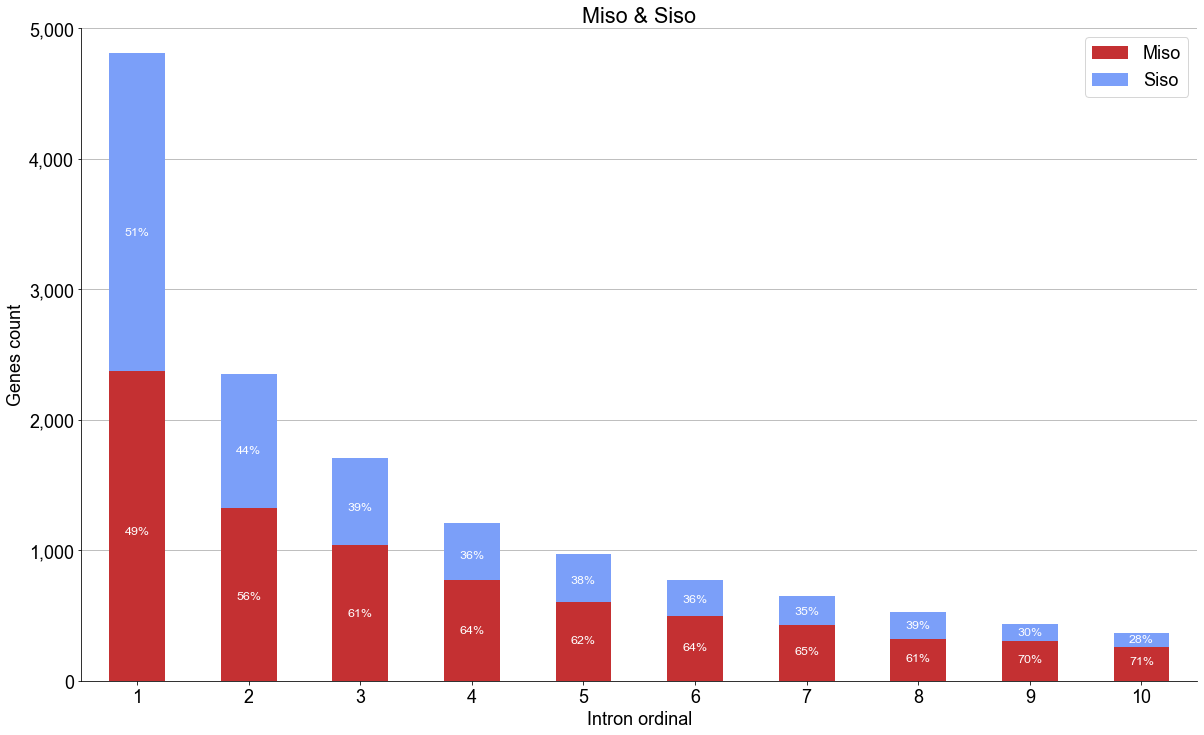

In [38]:
# plt.style.use('default')
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        i = 1
        s_sum = list()
        s_sum_complete = list()
        for p in ax.patches:
            s_sum.append(p.get_height())
            if i % 10 == 0 :
                s_sum_complete.append(s_sum)
                s_sum = list()
            i += 1
        
        s_sum_complete = list(zip(s_sum_complete[0], s_sum_complete[1]))
        s_sum_complete = [sum(e) for e in s_sum_complete]
        s_sum_complete = s_sum_complete + s_sum_complete

        i = 0
        for p in ax.patches:

#             print('\n')
#             print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
            print(p.get_height(), s_sum_complete[i])
            ax.text(_x, _y  - _y / 20, str(int(100 * round(float(p.get_height() / s_sum_complete[i]), 2))) + "%", ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')
            i += 1

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
        
        
plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(20,12))
t_plot = t_introns.loc[(t_introns['Intron_length_max_index'] <= 10) & (t_introns['CDS_count'] >= 2)]
t_plot = t_plot.groupby(["Miso_siso", 'Intron_length_max_index'])['Gene'].count().reset_index()
t_count = t_introns.groupby(["Miso_siso", 'Intron_length_max_index'])['Gene'].count().reset_index()
t_plot = t_plot.pivot(index='Intron_length_max_index', columns='Miso_siso', values='Gene')
t_count = t_count.pivot(index='Intron_length_max_index', columns='Miso_siso', values='Gene')

t_plot.plot(kind='bar', stacked=True, color=list(palette.values()), ax=ax)
# sns.barplot(data=t_plot, x='Intron_length_max_index', y='Gene', hue='Miso_siso', palette=palette)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.set_xlabel('Intron ordinal')
ax.set_ylabel('Genes count')
ax.set_ylim(0,5e3)
ax.set_title('Miso & Siso')
ax.set_axisbelow(True)
ax.grid(axis='y')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(title='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.set_yscale('log')
# ax.text(-2.5, 3200, 'B', size='large', weight='bold')

show_values_on_bars(ax, fontsize=9)
# ax.legend(title='')
t_count['CS_Miso'] = 100  * (t_count['Miso'].cumsum()  / t_count['Miso'].sum())
t_count['R_Miso'] = 100  * (t_count['Miso']  / t_count['Miso'].sum())
t_count['CS_Siso'] = 100  * (t_count['Siso'].cumsum()  / t_count['Siso'].sum())
t_count['R_Siso'] = 100  * (t_count['Siso']  / t_count['Siso'].sum())
t_count

1491.0 2960.0
1385.0 2722.0
1019.0 1878.0
1033.0 1648.0
824.0 1231.0
700.0 1006.0
584.0 835.0
483.0 698.0
440.0 608.0
378.0 517.0
1469.0 2960.0
1337.0 2722.0
859.0 1878.0
615.0 1648.0
407.0 1231.0
306.0 1006.0
251.0 835.0
215.0 698.0
168.0 608.0
139.0 517.0


Miso_siso,Miso,Siso,CS_Miso,R_Miso,CS_Siso,R_Siso
Exon_length_max_index,,,,,,
1,1789.0,3153.0,16.357319,16.357319,37.674752,37.674752
2,1385.0,1337.0,29.020755,12.663436,53.650376,15.975624
3,1019.0,859.0,38.337753,9.316997,63.914446,10.264070
4,1033.0,615.0,47.782756,9.445003,71.262994,7.348548
5,824.0,407.0,55.316814,7.534059,76.126180,4.863186
...,...,...,...,...,...,...
91,1.0,NaN,99.981713,0.009143,NaN,NaN
92,NaN,1.0,NaN,NaN,99.988051,0.011949
106,1.0,NaN,99.990857,0.009143,NaN,NaN


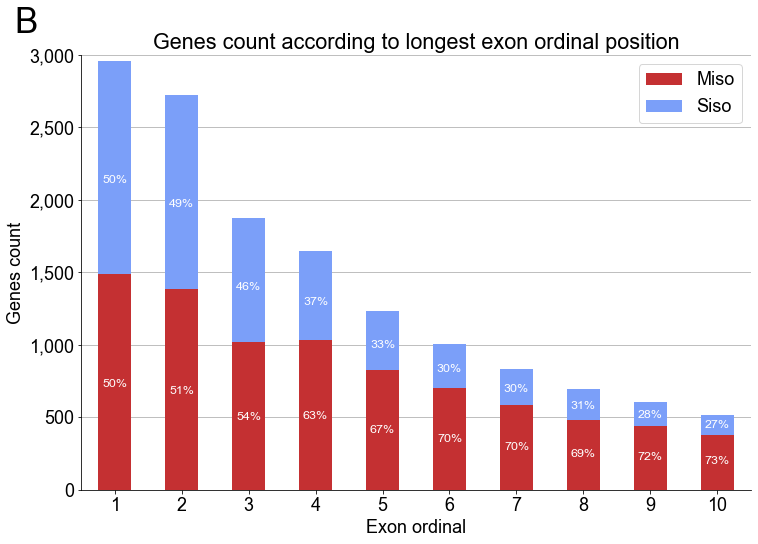

In [66]:
# plt.style.use('default')
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        i = 1
        s_sum = list()
        s_sum_complete = list()
        for p in ax.patches:
            s_sum.append(p.get_height())
            if i % 10 == 0 :
                s_sum_complete.append(s_sum)
                s_sum = list()
            i += 1
        
        s_sum_complete = list(zip(s_sum_complete[0], s_sum_complete[1]))
        s_sum_complete = [sum(e) for e in s_sum_complete]
        s_sum_complete = s_sum_complete + s_sum_complete

        i = 0
        for p in ax.patches:

#             print('\n')
#             print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
            print(p.get_height(), s_sum_complete[i])
            ax.text(_x, _y  - _y / 20, str(int(100 * round(float(p.get_height() / s_sum_complete[i]), 2))) + "%", ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')
            i += 1

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
        
        
plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(12,8))
t_plot = t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['CDS_count'] >= 2)]
t_plot = t_plot.groupby(["Miso_siso", 'Exon_length_max_index'])['Gene'].count().reset_index()
t_count = t_exons.groupby(["Miso_siso", 'Exon_length_max_index'])['Gene'].count().reset_index()
t_plot = t_plot.pivot(index='Exon_length_max_index', columns='Miso_siso', values='Gene')
t_count = t_count.pivot(index='Exon_length_max_index', columns='Miso_siso', values='Gene')

t_plot.plot(kind='bar', stacked=True, color=list(palette.values()), ax=ax)
# sns.barplot(data=t_plot, x='Intron_length_max_index', y='Gene', hue='Miso_siso', palette=palette)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.set_xlabel('Exon ordinal')
ax.set_ylabel('Genes count')
ax.set_ylim(0,3e3)
# ax.set_title('Miso & Siso')
ax.set_title('Genes count according to longest exon ordinal position')

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(title='')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.set_yscale('log')
# ax.text(-2.5, 3200, 'B', size='large', weight='bold')

show_values_on_bars(ax, fontsize=9)
# ax.legend(title='')
t_count['CS_Miso'] = 100  * (t_count['Miso'].cumsum()  / t_count['Miso'].sum())
t_count['R_Miso'] = 100  * (t_count['Miso']  / t_count['Miso'].sum())
t_count['CS_Siso'] = 100  * (t_count['Siso'].cumsum()  / t_count['Siso'].sum())
t_count['R_Siso'] = 100  * (t_count['Siso']  / t_count['Siso'].sum())
ax.text(-0.1, 1.05, "B", transform=ax.transAxes, size=35, weight='bold')
t_count

In [ ]:
# plt.style.use('default')
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        i = 1
        s_sum = list()
        s_sum_complete = list()
        for p in ax.patches:
            print(i, p.get_height())
            s_sum.append(p.get_height())
            if i % 10 == 0 :
                s_sum_complete.append(s_sum)
                s_sum = list()
            i += 1
        
        s_sum_complete = list(zip(s_sum_complete[0], s_sum_complete[1]))
        s_sum_complete = [sum(e) for e in s_sum_complete]
        s_sum_complete = s_sum_complete + s_sum_complete

        i = 0
        for p in ax.patches:

#             print('\n')
#             print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
#             ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
#             print(p.get_height(), s_sum_complete[i])
            ax.text(_x, _y  - _y / 20, str(int(100 * round(float(p.get_height() / s_sum_complete[i]), 2))) + "%", ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')
            i += 1

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
        
        
plt.rcParams.update({'font.size' : 18})
f, ax = plt.subplots(figsize=(22,12))
# t_plot = t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['CDS_count'] >= 1)]
# t_plot = t_plot.groupby(["Miso_siso", 'Exon_length_max_index'])['Gene'].count().reset_index()
# t_plot = t_plot.pivot(index='Exon_length_max_index', columns='Miso_siso', values='Gene')
# t_plot.plot(kind='bar', stacked=True, color=list(palette.values()), ax=ax)
# # sns.barplot(data=t_plot, x='Intron_length_max_index', y='Gene', hue='Miso_siso', palette=palette)
# ax.spines['right'].set_linewidth(0)
# ax.spines['top'].set_linewidth(0)
# ax.set_xlabel('Exon ordinal')
# ax.set_ylabel('Genes count')
# ax.set_ylim(0,5e3)
# ax.set_title('Miso & Siso')
# ax.set_axisbelow(True)
# ax.grid(axis='y')
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.legend(title='')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# # ax.set_yscale('log')
# # ax.text(-2.5, 3200, 'B', size='large', weight='bold')

# # show_values_on_bars(ax, fontsize=9)
                    
                    
                    
t_plot = t_introns.loc[(t_introns['Intron_length_max_index'] <= 10) & (t_introns['CDS_count'] >= 2)]
t_plot = t_plot.groupby(["Miso_siso", 'Intron_length_max_index'])['Gene'].count().reset_index()
t_plot = t_plot.pivot(index='Intron_length_max_index', columns='Miso_siso', values='Gene')

labels = [e-1 for e in t_plot.index.tolist()]
width = 0.4


ax.bar([e-width/2 for e in range(len(labels))], t_plot.Miso.values.tolist(), width=width, label='Miso',
       color=palette['Miso'], hatch="///")

ax.bar([e-width/2 for e in range(len(labels))], t_plot.Siso.values.tolist(), width=width, label='Siso', bottom=t_plot.Miso.values.tolist(),
       color=palette['Siso'], hatch="///")

t_plot = t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['CDS_count'] >= 1)]
t_plot = t_plot.groupby(["Miso_siso", 'Exon_length_max_index'])['Gene'].count().reset_index()
t_plot = t_plot.pivot(index='Exon_length_max_index', columns='Miso_siso', values='Gene')

ax.bar([e+width/2 for e in range(len(labels))], t_plot.Miso.values.tolist(), width=width, label='Miso',
       color=palette['Miso'],)

ax.bar([e+width/2 for e in range(len(labels))], t_plot.Siso.values.tolist(), width=width, label='Siso', bottom=t_plot.Miso.values.tolist(),
       color=palette['Siso'], )


# sns.barplot(data=t_plot, x='Intron_length_max_index', y='Gene', hue='Miso_siso', palette=palette)
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.set_xlabel('Ordinal position (Intron & Exon)')
ax.set_ylabel('Genes count')
ax.set_ylim(0,5e3)
ax.set_xlim(-0.5,9.5)
ax.set_title('Miso & Siso')
ax.set_axisbelow(True)
ax.grid(axis='y')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(title='')
ax.set_xticks(labels)
ax.set_xticklabels(list([str(e) for e in range(1,11)]), rotation=0)
# h, l = ax.get_legend()
# ax.legend(h, [''])
# ax.set_yscale('log')
# ax.text(-2.5, 3200, 'B', size='large', weight='bold')

show_values_on_bars(ax, fontsize=9)
# ax.legend(title='')

In [ ]:
intron_plot_distri

In [10]:
def test_intron_nb(df):
#     print(df)
#     print(list(range(1, df.shape[0] + 1)))
    df['Intron_nb'] = list(range(1, df.shape[0] + 1))
#     print(df)
    return df

intron_plot_distri = pd.merge(genes[['Gene', 'Length']], refseq_introns_plot, on='Gene')

intron_plot_distri = intron_plot_distri.groupby('Gene').progress_apply(test_intron_nb)
intron_plot_distri = pd.merge(intron_plot_distri, refseq_wt_variable_drop_duplicates[['Gene', 'mRNA_gene_nb', 'CDS_count']].reset_index(drop=True).drop_duplicates(), on='Gene')

# t[['Gene', 'Length', 'Miso_siso', 'Introns_lengths', "Intron_nb"]].to_parquet('/gstock/EXOTIC/data/GENOMICS/genes_length_intronlength.parquet', index=False)
intron_plot_distri = intron_plot_distri.sort_values(by='Miso_siso')


100%|██████████| 17278/17278 [00:33<00:00, 510.73it/s] 


In [55]:
intron_plot_distri

,Gene,Length,Exons_ranges,Strand,Miso_siso,Introns_ranges,Introns_lengths,Intron_nb,mRNA_gene_nb,CDS_count
90348,PDSS1,49.374,"[26986641-26986769, 26991091-26991123, 2699360...",1,Miso,"[26986770-26991090, 26991124-26993605, 2699367...",2.481,2,3,15
106815,PRMT8,212.624,"[3490561-3490608, 3600792-3600866, 3649772-364...",1,Miso,"[3490609-3600791, 3600867-3649771, 3649958-365...",6.070,8,2,11
106814,PRMT8,212.624,"[3490561-3490608, 3600792-3600866, 3649772-364...",1,Miso,"[3490609-3600791, 3600867-3649771, 3649958-365...",7.305,7,2,11
106813,PRMT8,212.624,"[3490561-3490608, 3600792-3600866, 3649772-364...",1,Miso,"[3490609-3600791, 3600867-3649771, 3649958-365...",0.627,6,2,11
106812,PRMT8,212.624,"[3490561-3490608, 3600792-3600866, 3649772-364...",1,Miso,"[3490609-3600791, 3600867-3649771, 3649958-365...",14.990,5,2,11
...,...,...,...,...,...,...,...,...,...,...
119090,GPC5,1468.615,"[92051301-92051463, 92101015-92101176, 9234544...",1,Siso,"[92051464-92101014, 92101177-92345440, 9234613...",27.628,4,1,8
119089,GPC5,1468.615,"[92051301-92051463, 92101015-92101176, 9234544...",1,Siso,"[92051464-92101014, 92101177-92345440, 9234613...",34.649,3,1,8
119088,GPC5,1468.615,"[92051301-92051463, 92101015-92101176, 9234544...",1,Siso,"[92051464-92101014, 92101177-92345440, 9234613...",244.263,2,1,8
40189,SRPRB,44.551,"[133524693-133524846, 133525453-133525547, 133...",1,Siso,"[133524847-133525452, 133525548-133526589, 133...",0.605,1,1,7


   Miso_siso  Intron_nb  Introns_lengths
0       Miso          1         9.590812
1       Miso          2         6.823791
2       Miso          3         5.998876
3       Miso          4         5.646233
4       Miso          5         5.517898
5       Miso          6         5.376264
6       Miso          7         5.265373
7       Miso          8         5.288497
8       Miso          9         5.195730
9       Miso         10         5.514140
10      Siso          1         8.385321
11      Siso          2         5.257472
12      Siso          3         4.482016
13      Siso          4         4.377390
14      Siso          5         4.088179
15      Siso          6         4.262701
16      Siso          7         3.935850
17      Siso          8         3.758947
18      Siso          9         4.037233
19      Siso         10         4.000663
   Miso_siso  Intron_nb  Introns_lengths
0       Miso          1           2.0840
1       Miso          2           1.6805
2       Miso    

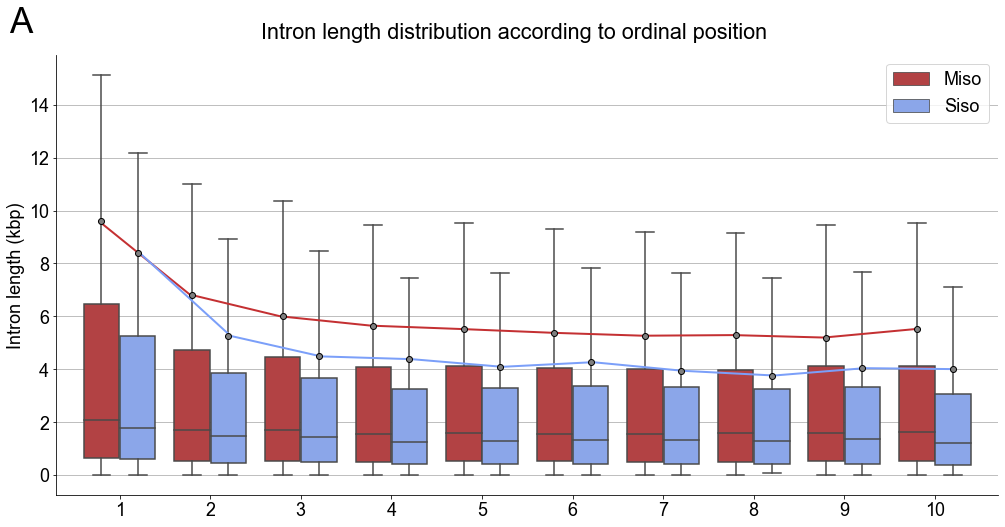

In [62]:
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }

# f = plt.figure(figsize=(15,10))
g = sns.FacetGrid(data=intron_plot_distri.loc[(intron_plot_distri['Intron_nb'] <= 10) & (intron_plot_distri['Intron_nb'] < intron_plot_distri['CDS_count'])].sort_values(by='Miso_siso'),  aspect=2, height=7, sharey=True, )
g.map_dataframe(sns.boxplot, x='Intron_nb', y='Introns_lengths', hue='Miso_siso', palette=palette, showfliers=False, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black"})
print(g.axes.ravel())
g.axes.ravel()[0].text(-0.05, 1.05, "A", transform=g.axes.ravel()[0].transAxes, size=35, weight='bold')
for j, ax in enumerate(g.axes.ravel()):
    
#     ax.set_ylim(0,1000)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if j % 2 == 0 :
        ax.set_ylabel('Intron length (kbp)')
plt.suptitle('Intron length distribution according to ordinal position', y=1.025)
# plt.text(-1.3, 15, 'A', fontsize=30, weight='bold')

means = intron_plot_distri.loc[(intron_plot_distri['Intron_nb'] <= 10) & (intron_plot_distri['Intron_nb'] < intron_plot_distri['CDS_count'])].groupby(['Miso_siso', 'Intron_nb'])['Introns_lengths'].mean().reset_index()
medians = intron_plot_distri.loc[(intron_plot_distri['Intron_nb'] <= 10) & (intron_plot_distri['Intron_nb'] < intron_plot_distri['CDS_count'])].groupby(['Miso_siso', 'Intron_nb'])['Introns_lengths'].median().reset_index()
for miso_siso, x_shift in zip(['Miso', 'Siso'], [-0.225,0.225]):
    tmp_df_means = means.loc[means['Miso_siso'] == miso_siso]
#     print(tmp_df)
#     print(tmp_df.Intron_nb)
#     print(tmp_df.Intron_nb.max())
    x = [e + x_shift for e in range(0,int(tmp_df_means.Intron_nb.max()))]
    plt.plot(x, tmp_df_means.Introns_lengths.values, lw=2, color=palette[miso_siso])
# plt.ylim(0,500)
print(means)
print(medians)

In [17]:
refseq_wt_variable_drop_duplicates.drop_duplicates(subset=['ranges_without_variable'])
# refseq_wt_variable_drop_duplicates

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,...,Ratio_num,Const_Alt,Share,CDS_count,ranges_without_variable,Miso_siso,Exon_start_raw,Exon_stop_raw,Length_raw,Exon_nb
0,A1BG,CDS,58864770-58864803,[NM_130786],58864770,58864803,33,0,1,[NM_130786],...,1.0,Const,False,8,58864770-58864803,Siso,58864770,58864803,33,1
1,A1BG,CDS,58864658-58864693,[NM_130786],58864658,58864693,35,0,1,[NM_130786],...,1.0,Const,False,8,58864658-58864693,Siso,58864658,58864693,35,2
2,A1BG,CDS,58864294-58864563,[NM_130786],58864294,58864563,269,0,1,[NM_130786],...,1.0,Const,False,8,58864294-58864563,Siso,58864294,58864563,269,3
3,A1BG,CDS,58863649-58863921,[NM_130786],58863649,58863921,272,0,1,[NM_130786],...,1.0,Const,False,8,58863649-58863921,Siso,58863649,58863921,272,4
4,A1BG,CDS,58862757-58863053,[NM_130786],58862757,58863053,296,0,1,[NM_130786],...,1.0,Const,False,8,58862757-58863053,Siso,58862757,58863053,296,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205622,ZZZ3,CDS,78044459-78044554,"[NM_001308237, NM_015534]",78044459,78044554,95,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78044459-78044554,Miso,78044459,78044554,95,8
205623,ZZZ3,CDS,78041753-78041905,"[NM_001308237, NM_015534]",78041753,78041905,152,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78041753-78041905,Miso,78041753,78041905,152,9
205624,ZZZ3,CDS,78034017-78034151,"[NM_001308237, NM_015534]",78034017,78034151,134,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78034017-78034151,Miso,78034017,78034151,134,10
205625,ZZZ3,CDS,78031766-78031866,"[NM_001308237, NM_015534]",78031766,78031866,100,0,2,"[NM_015534, NM_001308237]",...,1.0,Const,False,12,78031766-78031866,Miso,78031766,78031866,100,11


In [64]:
refseq_wt_variable_drop_duplicates.loc[(refseq_wt_variable_drop_duplicates['Exon_nb'] <= 10) & (refseq_wt_variable_drop_duplicates['Exon_nb'] >= refseq_wt_variable_drop_duplicates['CDS_count'])]

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,...,Ratio_num,Const_Alt,Share,CDS_count,ranges_without_variable,Miso_siso,Exon_start_raw,Exon_stop_raw,Length_raw,Exon_nb
7,A1BG,CDS,58858388-58858395,[NM_130786],58858388,58858395,7,0,1,[NM_130786],...,1.0,Const,False,8,58858388-58858395,Siso,58858388,58858395,7,8
96,A3GALT2,CDS,33772367-33773054,[NM_001080438],33772367,33773054,687,0,1,[NM_001080438],...,1.0,Const,False,5,33772367-33773054,Siso,33772367,33773054,687,5
97,A4GALT,CDS,43088896-43089957,"[NM_001318038, NM_017436]",43088896,43089957,1061,0,2,"[NM_017436, NM_001318038]",...,1.0,Const,False,1,43088896-43089957,Miso,43088896,43089957,1061,1
99,A4GNT,CDS,137843106-137843720,[NM_016161],137843106,137843720,614,0,1,[NM_016161],...,1.0,Const,False,2,137843106-137843720,Siso,137843106,137843720,614,2
138,AADAC,CDS,151545364-151545960,[NM_001086],151545364,151545960,596,1,1,[NM_001086],...,1.0,Const,False,5,151545364-151545960,Siso,151545364,151545960,596,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205427,ZSWIM7,CDS,15881361-15881477,"[NM_001042698, NM_001042697]",15881361,15881477,116,0,2,"[NM_001042697, NM_001042698]",...,1.0,Const,False,5,15881361-15881477,Miso,15881361,15881477,116,5
205456,ZSWIM9,CDS,48697910-48700084,[NM_199341],48697910,48700084,2174,1,1,[NM_199341],...,1.0,Const,False,3,48697910-48700084,Siso,48697910,48700084,2174,3
205509,ZXDA,CDS,57934455-57936854,[NM_007156],57934455,57936854,2399,0,1,[NM_007156],...,1.0,Const,False,1,57934455-57936854,Siso,57934455,57936854,2399,1
205510,ZXDB,CDS,57618482-57620893,[NM_007157],57618482,57620893,2411,1,1,[NM_007157],...,1.0,Const,False,1,57618482-57620893,Siso,57618482,57620893,2411,1


   Miso_siso  Exon_nb  Length_raw
0       Miso        1  208.587757
1       Miso        2  175.013944
2       Miso        3  171.841149
3       Miso        4  169.820712
4       Miso        5  164.524655
5       Miso        6  156.089628
6       Miso        7  155.955272
7       Miso        8  150.855407
8       Miso        9  151.366672
9       Miso       10  147.569233
10      Siso        1  384.524676
11      Siso        2  222.336651
12      Siso        3  181.252277
13      Siso        4  195.174544
14      Siso        5  155.943036
15      Siso        6  152.717886
16      Siso        7  147.464364
17      Siso        8  152.762772
18      Siso        9  151.265700
19      Siso       10  153.527222
   Miso_siso  Exon_nb  Length_raw
0       Miso        1          98
1       Miso        2         118
2       Miso        3         119
3       Miso        4         119
4       Miso        5         119
5       Miso        6         116
6       Miso        7         118
7       Miso  

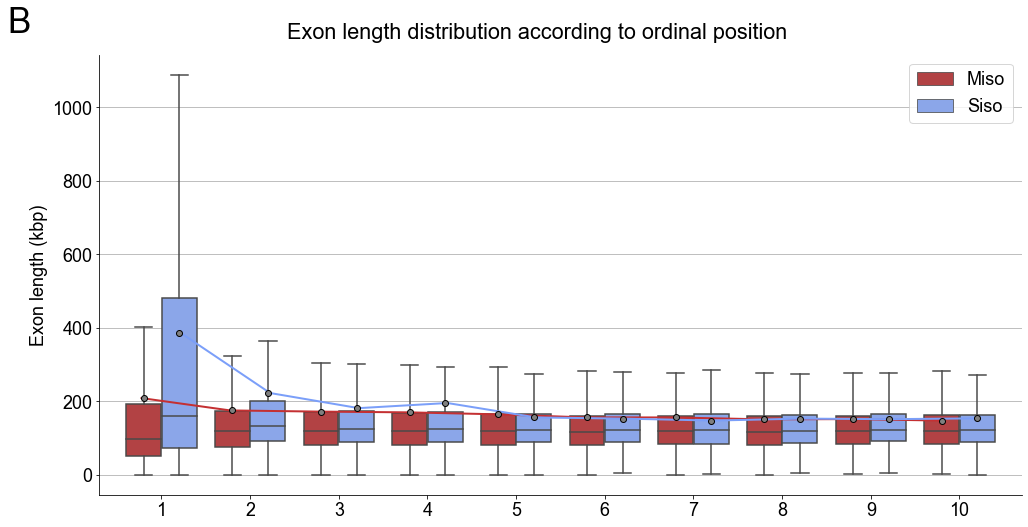

In [22]:

# f = plt.figure(figsize=(15,10))
refseq_wt_variable_drop_duplicates = refseq_wt_variable_drop_duplicates.drop_duplicates(subset=['ranges_without_variable'])

g = sns.FacetGrid(data=refseq_wt_variable_drop_duplicates.loc[(refseq_wt_variable_drop_duplicates['Exon_nb'] <= 10) & (refseq_wt_variable_drop_duplicates['Exon_nb'] <= refseq_wt_variable_drop_duplicates['CDS_count'])].sort_values(by='Miso_siso'),  aspect=2, height=7, sharey=True, )
g.map_dataframe(sns.boxplot, x='Exon_nb', y='Length_raw', hue='Miso_siso', palette=palette, showfliers=False, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black"})
print(g.axes.ravel())
g.axes.ravel()[0].text(-0.1, 1.05, "B", transform=g.axes.ravel()[0].transAxes, size=35, weight='bold')
for j, ax in enumerate(g.axes.ravel()):
    
#     ax.set_ylim(0,1000)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if j % 2 == 0 :
        ax.set_ylabel('Exon length (kbp)')
plt.suptitle('Exon length distribution according to ordinal position', y=1.025)
# plt.text(-1.3, 15, 'A', fontsize=30, weight='bold')

means = refseq_wt_variable_drop_duplicates.loc[(refseq_wt_variable_drop_duplicates['Exon_nb'] <= 10) & (refseq_wt_variable_drop_duplicates['Exon_nb'] <= refseq_wt_variable_drop_duplicates['CDS_count'])].groupby(['Miso_siso', 'Exon_nb'])['Length_raw'].mean().reset_index()
medians = refseq_wt_variable_drop_duplicates.loc[(refseq_wt_variable_drop_duplicates['Exon_nb'] <= 10) & (refseq_wt_variable_drop_duplicates['Exon_nb'] <= refseq_wt_variable_drop_duplicates['CDS_count'])].groupby(['Miso_siso', 'Exon_nb'])['Length_raw'].median().reset_index()
for miso_siso, x_shift in zip(['Miso', 'Siso'], [-0.225,0.225]):
    tmp_df_means = means.loc[means['Miso_siso'] == miso_siso]
#     print(tmp_df)
#     print(tmp_df.Intron_nb)
#     print(tmp_df.Intron_nb.max())
    x = [e + x_shift for e in range(0,int(tmp_df_means.Exon_nb.max()))]
    plt.plot(x, tmp_df_means.Length_raw.values, lw=2, color=palette[miso_siso])
# plt.ylim(0,500)
print(means)
print(medians)

In [54]:
t_exons

,Gene,Length,Miso_siso,Exon_length_max,Exon_length_max_index,mRNA_gene_nb,CDS_count,Strand
0,A1BG,33,Siso,296,5,1,8,0
1,A1CF,98,Miso,273,8,8,13,0
2,A2M,85,Miso,228,19,4,38,0
3,A2ML1,61,Miso,228,20,2,36,1
4,A3GALT2,22,Siso,687,5,1,5,0
...,...,...,...,...,...,...,...,...
19301,ZYG11A,89,Miso,751,3,2,15,1
19302,ZYG11B,29,Siso,754,3,1,14,1
19303,ZYX,207,Miso,521,4,3,9,1
19304,ZZEF1,353,Siso,468,29,1,55,0


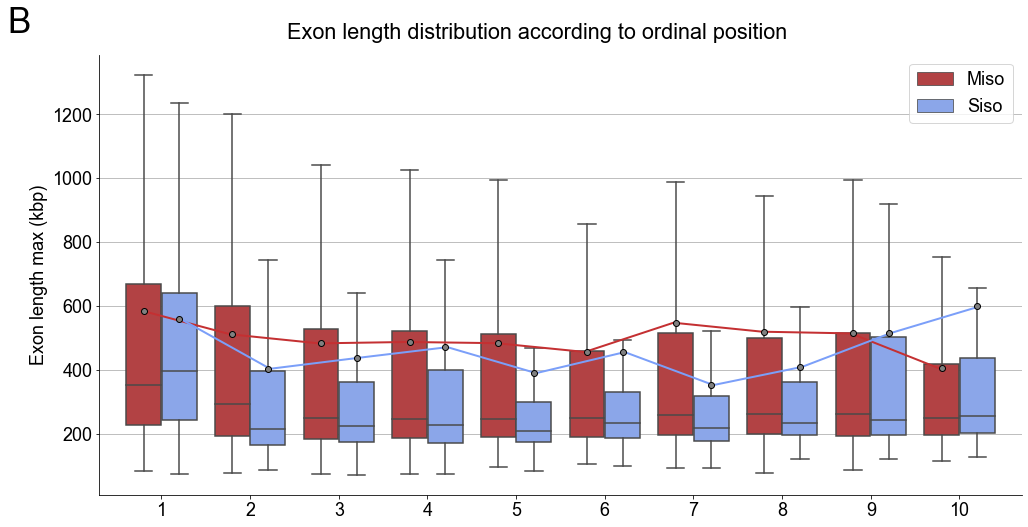

In [60]:

# f = plt.figure(figsize=(15,10))
# refseq_wt_variable_drop_duplicates = refseq_wt_variable_drop_duplicates.drop_duplicates(subset=['ranges_without_variable'])

g = sns.FacetGrid(data=t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['Exon_length_max_index'] < t_exons['CDS_count'])].sort_values(by='Miso_siso'),  aspect=2, height=7, sharey=True, )
g.map_dataframe(sns.boxplot, x='Exon_length_max_index', y='Exon_length_max', hue='Miso_siso', palette=palette, showfliers=False, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black"})
print(g.axes.ravel())
g.axes.ravel()[0].text(-0.1, 1.05, "B", transform=g.axes.ravel()[0].transAxes, size=35, weight='bold')
for j, ax in enumerate(g.axes.ravel()):
    
#     ax.set_ylim(0,1000)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if j % 2 == 0 :
        ax.set_ylabel('Exon length max (kbp)')
plt.suptitle('Exon length distribution according to ordinal position', y=1.025)
# plt.text(-1.3, 15, 'A', fontsize=30, weight='bold')

means = t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['Exon_length_max_index'] < t_exons['CDS_count'])].groupby(['Miso_siso', 'Exon_length_max_index'])['Exon_length_max'].mean().reset_index()
medians = t_exons.loc[(t_exons['Exon_length_max_index'] <= 10) & (t_exons['Exon_length_max_index'] < t_exons['CDS_count'])].groupby(['Miso_siso', 'Exon_length_max_index'])['Exon_length_max'].median().reset_index()
for miso_siso, x_shift in zip(['Miso', 'Siso'], [-0.225,0.225]):
    tmp_df_means = means.loc[means['Miso_siso'] == miso_siso]
#     print(tmp_df)
#     print(tmp_df.Intron_nb)
#     print(tmp_df.Intron_nb.max())
    x = [e + x_shift for e in range(0,int(tmp_df_means.Exon_length_max_index.max()))]
    plt.plot(x, tmp_df_means.Exon_length_max.values, lw=2, color=palette[miso_siso])
# plt.ylim(0,500)

In [ ]:
# plt.style.use('default')
def show_values_on_bars(axs, i=0, fontsize=13, rotation=0, padding=1):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            print(p)
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height()) + padding
            if i == 0:
                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=fontsize, rotation=rotation, color='black')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

f, ax = plt.subplots(nrows=2, figsize=(18,10))



sns.barplot(data=t.loc[t['CDS_count'] <= 30].groupby('CDS_count')['Exon_length_max'].mean().reset_index(), x='CDS_count', y='Exon_length_max', palette=['grey'], ax=ax[0])
ax[0].spines['right'].set_linewidth(0)
ax[0].spines['top'].set_linewidth(0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Longest exon mean length (bp)')
ax[0].set_axisbelow(True)
ax[0].grid(axis='y')
show_values_on_bars(ax[0], fontsize=11, padding=10)




sns.barplot(data=t.loc[t['CDS_count'] <= 30].groupby(['Miso_siso', 'CDS_count'])['Exon_length_max'].mean().reset_index(), x='CDS_count', y='Exon_length_max', hue='Miso_siso', palette=palette, ax=ax[1])
ax[1].spines['right'].set_linewidth(0)
ax[1].spines['top'].set_linewidth(0)
ax[1].set_xlabel('Number of exons in the gene')
ax[1].set_ylabel('Longest exon mean length (bp)')
ax[1].set_axisbelow(True)
ax[1].grid(axis='y')
ax[1].legend(title='', ncol=2, loc='upper center')
show_values_on_bars(ax[1], fontsize=11, padding=10)

i = 0
for n, sub_a in enumerate(ax):
    sub_a.text(-0.1, 1.05, string.ascii_uppercase[i], transform=sub_a.transAxes, size=35, weight='bold')
    i += 1 
plt.tight_layout()

In [ ]:
tmp = refseq_wt_variable_drop_duplicates.copy()
tmp['Gene_size_type'] = pd.cut(tmp['CDS_count'], [0,10,15,22,max(t['CDS_count'])], labels=['Small', 'Medium1', 'Medium2', 'Large'])
tmp = tmp.sort_values(by=['Miso_siso'])
tmp




# f, ax = plt.subplots(nrows=1, figsize=(15,8))


    

# sns.boxplot(data=tmp.loc[tmp['Exon_nb'] <= 10], x='Exon_nb', y='Length_raw', hue='Miso_siso', showfliers=False, palette=palette, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black"}, ax=ax)
# plt.ylim(0,1200)
# ax.spines['right'].set_linewidth(0)
# ax.spines['top'].set_linewidth(0)
# ax.set_xlabel('Exon ordinal position')
# ax.set_ylabel('Exon length (bp)')
# ax.set_axisbelow(True)
# ax.grid(axis='y')
# ax.set_title('Miso & Siso')

# handles, labels = ax.get_legend_handles_labels()

# ax.legend(handles=handles + [
#     matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
#     matplotlib.lines.Line2D([0], [0], color='black', lw=1)
# ],  
#           labels=labels + ['Mean', "Median"], title='', ncol=2)

# medians = tmp.loc[tmp['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['Length_raw'].median()
# means = tmp.loc[tmp['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['Length_raw'].mean()
# vertical_offset = tmp['Length_raw'].median() * 0.22 # offset from median for display
# x_cat = tmp.Miso_siso.unique().tolist()

# for cat, x_shift in zip(sorted(t.Miso_siso.unique()), [-0.18,+0.22]):
#     ax.plot(np.array(range(0,10)) + x_shift, means[cat].values, color=palette[cat], lw=3)

# # for j, xtick in enumerate(ax[1].get_xticks()):
# #     for cat, x_shift in zip(sorted(t.Miso_siso.unique()), [-0.18,+0.22]):
# #         ax[1].text(xtick + x_shift, medians[cat][xtick+1] - vertical_offset, int(medians[cat][xtick+1]), 
# #                 horizontalalignment='center',size='x-small',color='w',weight='semibold', rotation=90)

# # i = 0
# # for n, sub_a in enumerate(ax):
# #     sub_a.text(-0.05, 1.05, string.ascii_uppercase[i], transform=sub_a.transAxes, size=35, weight='bold')
# #     i += 1 